In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tan = yf.download("TAN", start="2005-01-01", end="2025-12-12")
clean = yf.download("iCLN", start="2005-01-01", end="2025-12-12")
cl = yf.download("CL=F", start="2005-01-01", end="2025-12-12")
etransition = yf.download("INRG.L", start="2005-01-01", end="2025-12-12")

/FutureWarning: YF.download() has changed argument auto_adjust default to True
  tan = yf.download("TAN", start="2005-01-01", end="2025-12-12")
[*********************100%***********************]  1 of 1 completed
/FutureWarning: YF.download() has changed argument auto_adjust default to True
  clean = yf.download("iCLN", start="2005-01-01", end="2025-12-12")
[*********************100%***********************]  1 of 1 completed
/FutureWarning: YF.download() has changed argument auto_adjust default to True
  cl = yf.download("CL=F", start="2005-01-01", end="2025-12-12")
[*********************100%***********************]  1 of 1 completed
/FutureWarning: YF.download() has changed argument auto_adjust default to True
  etransition = yf.download("INRG.L", start="2005-01-01", end="2025-12-12")
[*********************100%***********************]  1 of 1 completed


In [5]:
# 1. Select the 'Adj Close' column from each variable and rename it to the asset name
df_combined = pd.concat(
    [
        tan['Close'], 
        cl['Close'], 
        clean['Close'], 
        etransition['Close']
    ], 
    axis=1
)

# 2. Rename the columns to something meaningful
df_combined.columns = ['TAN', 'Oil', 'ICLN', 'INRG']

# 3. (Optional) Handle missing data 
# Since INRG.L trades in London and others in US, drop rows where all are NaN, 
# or forward fill previous prices to fill gaps.
df_combined = df_combined.ffill().dropna()

print(df_combined.head())

                  TAN        Oil       ICLN        INRG
Date                                                   
2009-01-02  68.553833  46.340000  15.887174  880.966370
2009-01-05  70.550545  48.810001  16.302294  899.260742
2009-01-06  70.106834  48.580002  16.056036  860.825562
2009-01-07  64.338547  42.630001  15.106184  818.527893
2009-01-08  67.222694  41.700001  15.591663  817.410095


In [21]:
# 1. Force the price columns to be numbers (floats)
cols_to_fix = ['TAN', 'ICLN', 'Oil']
for col in cols_to_fix:
    # 'coerce' turns any bad non-number data into NaN so it doesn't crash
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

# 2. Drop any rows that became NaN (empty)
df_combined.dropna(inplace=True)

print("Data Types Fixed!")
print(df_combined.dtypes) 
# You should see float64 for TAN, ICLN, Oil.

# 1. Create the buckets again (Categorical data)
df_combined['Oil_Category'] = pd.qcut(df_combined['Oil'], 3, labels=["Low Price", "Medium Price", "High Price"])

# 2. Calculate the mean, explicitly selecting ONLY the numeric columns (TAN, ICLN)
# We group by 'Oil_Category', but we only calculate the mean for 'TAN' and 'ICLN'
summary = df_combined.groupby('Oil_Category')[['TAN', 'ICLN','INRG']].mean()

print(summary)


Data Types Fixed!
TAN                  float64
Oil                  float64
ICLN                 float64
INRG                 float64
Oil_Category        category
TAN_Returns          float64
TAN_Returns_20MA     float64
dtype: object
                    TAN       ICLN        INRG
Oil_Category                                  
Low Price     33.359152  10.488051  505.595533
Medium Price  51.839509  14.170948  664.756572
High Price    41.576670  10.771626  514.329634


/var/folders/_1/hfj8zq4503j_64m7p0snclz40000gn/T/ipykernel_25355/1858728295.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_combined.groupby('Oil_Category')[['TAN', 'ICLN','INRG']].mean()


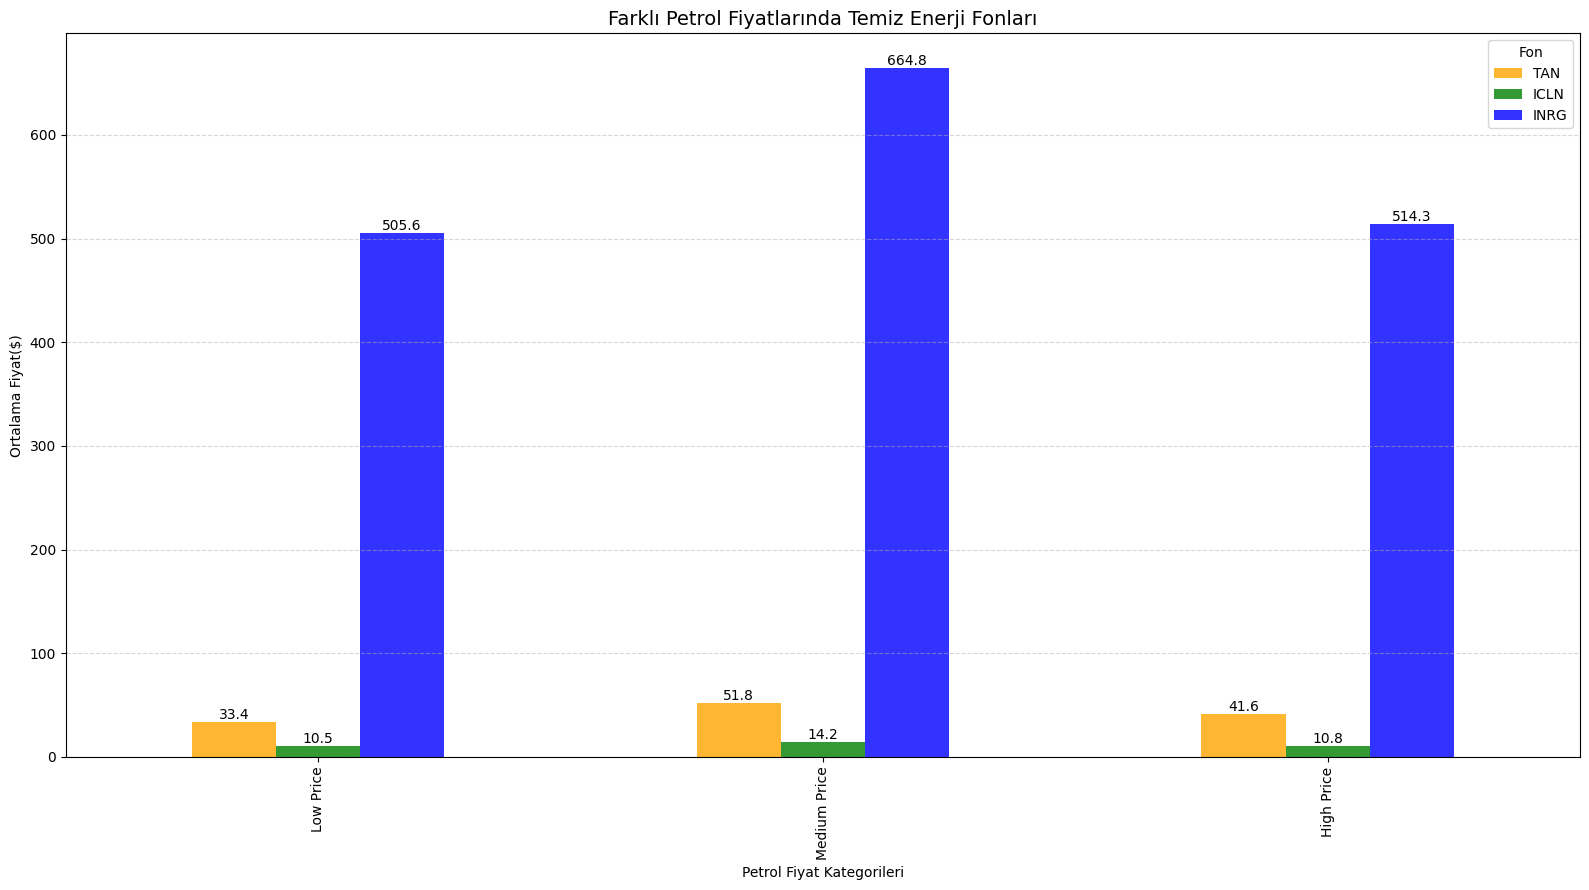

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'summary' is the dataframe from your previous groupby step
# and 'df_combined' is your main dataframe

# Create a figure with 2 subplots side-by-side
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 9))

# --- Graph 1: The Bar Chart (Buckets) ---
# This visualizes the table you just created
summary.plot(kind='bar', ax=ax1, color=['orange', 'green','blue'], alpha=0.8)
ax1.set_title('Farklı Petrol Fiyatlarında Temiz Enerji Fonları', fontsize=14)
ax1.set_ylabel('Ortalama Fiyat($)')
ax1.set_xlabel('Petrol Fiyat Kategorileri')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend(title='Fon')

# Add text labels on top of bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f')



plt.tight_layout()
plt.show()

In [10]:
#import seaborn as sns

#plt.figure(figsize=(12, 6))

# 1. Plot a thin grey line to show the continuous movement
#plt.plot(df_combined.index, df_combined['TAN'], color='lightgrey', linewidth=1, zorder=1)

# 2. Plot colored dots on top
# We use seaborn because it handles the coloring automatically
#sns.scatterplot(data=df_combined, x=df_combined.index, y='INRG', 
#                hue='Oil_Category', palette={'Low Price': 'green', 'Medium Price': 'orange', 'High Price': 'red'},
#                s=20, zorder=2) # s is point size
#plt.title('TAN Price with Oil Price Indicators')
#plt.show()

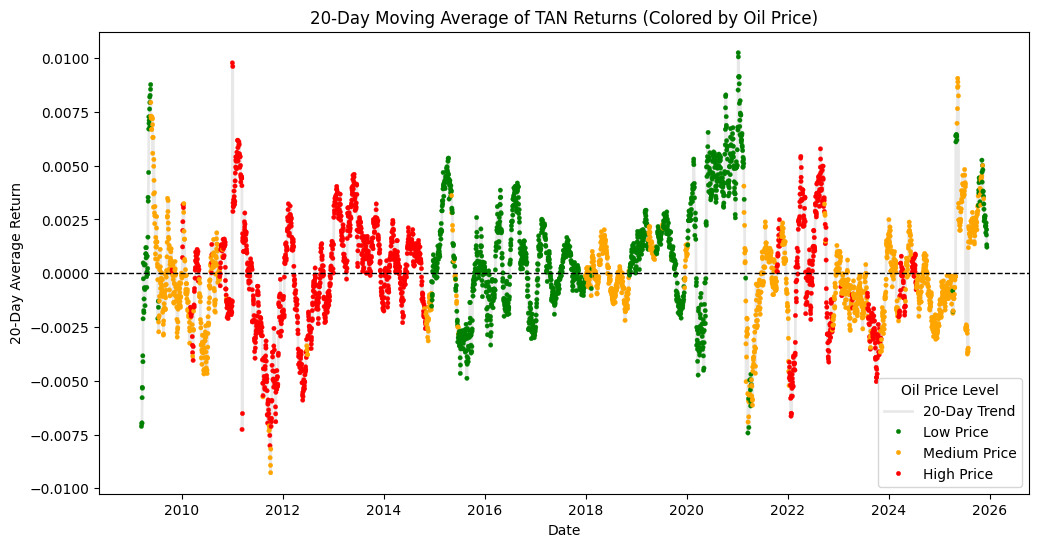

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the 20-Day Moving Average of Returns
# This smooths out the noise to show the monthly trend
df_combined['TAN_Returns'] = df_combined['INRG'].pct_change()
df_combined['TAN_Returns_20MA'] = df_combined['TAN_Returns'].rolling(window=50).mean()

# Drop the first 20 days which will be NaN
plot_data = df_combined.dropna(subset=['TAN_Returns_20MA'])

plt.figure(figsize=(12, 6))

# 2. Plot the grey continuous line (The Trend)
plt.plot(plot_data.index, plot_data['TAN_Returns_20MA'], 
         color='lightgrey', linewidth=2, alpha=0.5, zorder=1, label='20-Day Trend')

# 3. Plot the colored dots on top (The Oil Context)
sns.scatterplot(
    data=plot_data, 
    x=plot_data.index, 
    y='TAN_Returns_20MA', 
    hue='Oil_Category', 
    palette={'Low Price': 'green', 'Medium Price': 'orange', 'High Price': 'red'},
    s=10,  # Slightly larger dots for better visibility
    edgecolor=None,
    zorder=2
)

# Zero line: Above = Uptrend, Below = Downtrend
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('20-Day Moving Average of TAN Returns (Colored by Oil Price)')
plt.ylabel('20-Day Average Return')
plt.xlabel('Date')
plt.legend(title='Oil Price Level')
plt.show()

In [12]:
import pandas as pd

# Assuming df_combined already has 'TAN_Returns' and 'Oil_Category' from previous steps

# Define a custom function for Compound Return
# Formula: (1 + r1) * (1 + r2) * ... * (1 + rn) - 1
def compound_return(x):
    return (1 + x).prod() - 1

# Group by Oil Category and calculate the returns
results = df_combined.groupby('Oil_Category')['TAN_Returns'].agg(
    Total_Return=compound_return,
    Avg_Daily_Return='mean'
)

# Convert to percentage for easier reading
results_pct = results * 100

print("Return Analysis by Oil Price Region:")
print(results_pct.round(2).astype(str) + '%')

Return Analysis by Oil Price Region:
             Total_Return Avg_Daily_Return
Oil_Category                              
Low Price         270.37%            0.11%
Medium Price      -71.15%           -0.07%
High Price        -23.94%            0.01%


/var/folders/_1/hfj8zq4503j_64m7p0snclz40000gn/T/ipykernel_25355/1892883048.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df_combined.groupby('Oil_Category')['TAN_Returns'].agg(


In [13]:
df_combined.columns

Index(['TAN', 'Oil', 'ICLN', 'INRG', 'Oil_Category', 'TAN_Returns',
       'TAN_Returns_20MA'],
      dtype='object')

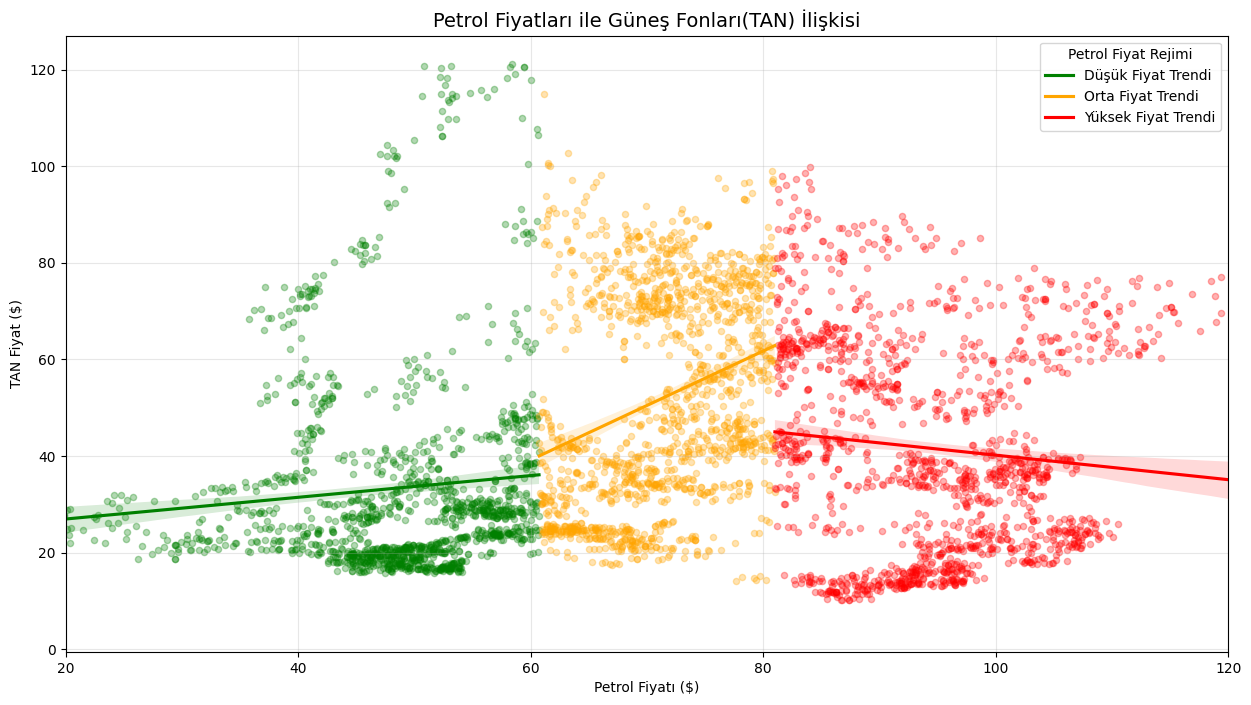

In [32]:


# Assuming 'df_combined' is already created and has 'Oil', 'TAN', 'Oil_Category' columns
# If not, ensure you have run the data preparation steps.

colors = {'Low Price': 'green', 'Medium Price': 'orange', 'High Price': 'red'}

# Create the figure
fig, ax2 = plt.subplots(1, 1, figsize=(15,8))

# Define a dictionary to map English data categories to Turkish Legend labels
label_translations = {
    'Low Price': 'Düşük Fiyat Trendi',
    'Medium Price': 'Orta Fiyat Trendi',
    'High Price': 'Yüksek Fiyat Trendi'
}

# Loop through each category to draw a specific trendline for it
for category, color in colors.items():
    # 1. Filter the data for just this bucket
    subset = df_combined[df_combined['Oil_Category'] == category]
    
    # 2. Plot the regression for this subset
    if not subset.empty: # Check to avoid errors if a bucket is empty
        sns.regplot(
            x='Oil', 
            y='TAN', #TAN
            data=subset, 
            ax=ax2,  # Draw on the existing axis
            color=color, # Sets color for both dots and line
            scatter_kws={'alpha': 0.3, 's': 20},
            line_kws={'label': label_translations[category]}
        )

# Formatting
ax2.set_title('Petrol Fiyatları ile Güneş Fonları(TAN) İlişkisi', fontsize=14)
ax2.set_ylabel('TAN Fiyat ($)')
ax2.set_xlabel('Petrol Fiyatı ($)')
ax2.legend(title='Petrol Fiyat Rejimi')
ax2.grid(True, alpha=0.3)

# --- KEY CHANGE: Limit the X-Axis ---
ax2.set_xlim(20, 120)

plt.show()

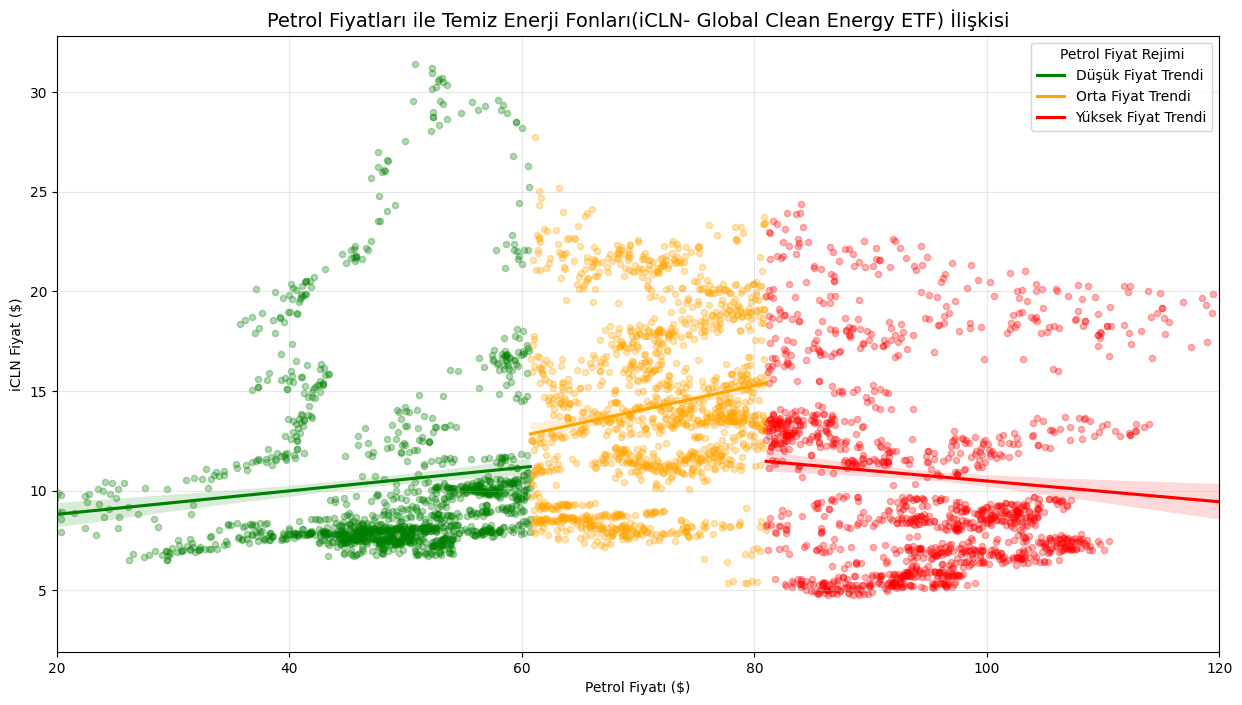

In [34]:


# Assuming 'df_combined' is already created and has 'Oil', 'TAN', 'Oil_Category' columns
# If not, ensure you have run the data preparation steps.

colors = {'Low Price': 'green', 'Medium Price': 'orange', 'High Price': 'red'}

# Create the figure
fig, ax2 = plt.subplots(1, 1, figsize=(15,8))

# Define a dictionary to map English data categories to Turkish Legend labels
label_translations = {
    'Low Price': 'Düşük Fiyat Trendi',
    'Medium Price': 'Orta Fiyat Trendi',
    'High Price': 'Yüksek Fiyat Trendi'
}

# Loop through each category to draw a specific trendline for it
for category, color in colors.items():
    # 1. Filter the data for just this bucket
    subset = df_combined[df_combined['Oil_Category'] == category]
    
    # 2. Plot the regression for this subset
    if not subset.empty: # Check to avoid errors if a bucket is empty
        sns.regplot(
            x='Oil', 
            y='ICLN', #TAN
            data=subset, 
            ax=ax2,  # Draw on the existing axis
            color=color, # Sets color for both dots and line
            scatter_kws={'alpha': 0.3, 's': 20},
            line_kws={'label': label_translations[category]}
        )

# Formatting
ax2.set_title('Petrol Fiyatları ile Temiz Enerji Fonları(iCLN- Global Clean Energy ETF) İlişkisi', fontsize=14)
ax2.set_ylabel('iCLN Fiyat ($)')
ax2.set_xlabel('Petrol Fiyatı ($)')
ax2.legend(title='Petrol Fiyat Rejimi')
ax2.grid(True, alpha=0.3)

# --- KEY CHANGE: Limit the X-Axis ---
ax2.set_xlim(20, 120)

plt.show()

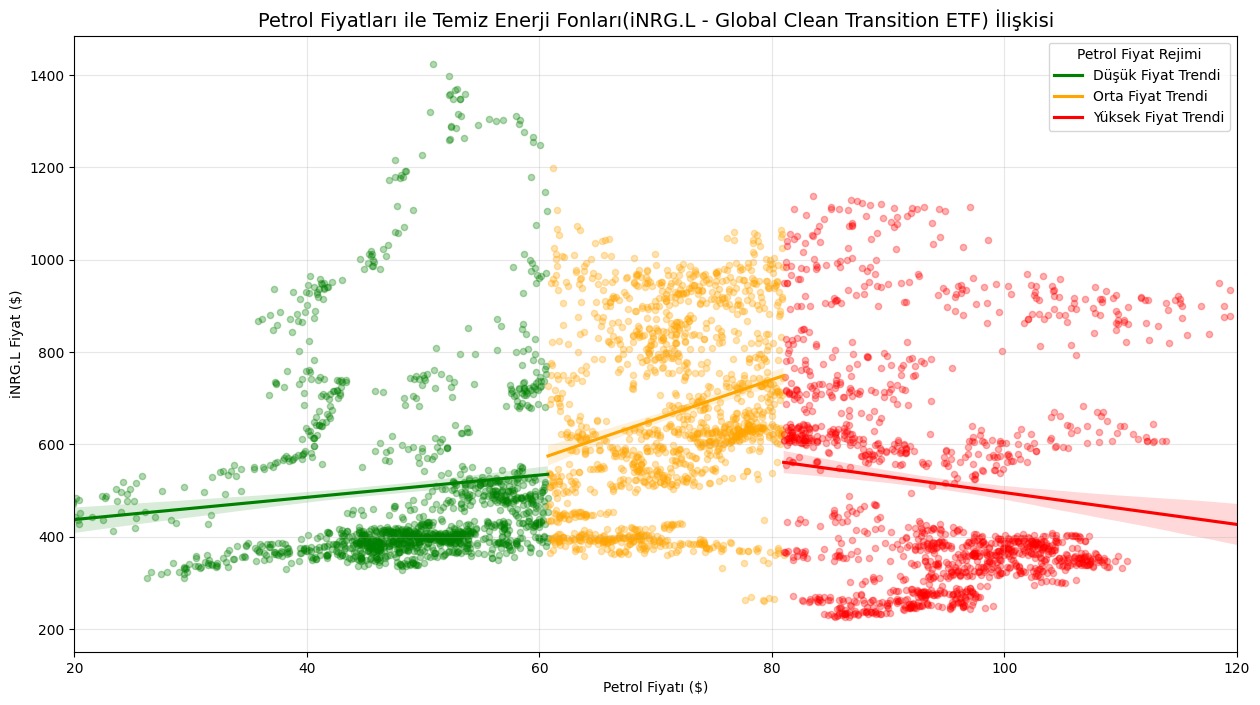

In [35]:


# Assuming 'df_combined' is already created and has 'Oil', 'TAN', 'Oil_Category' columns
# If not, ensure you have run the data preparation steps.

colors = {'Low Price': 'green', 'Medium Price': 'orange', 'High Price': 'red'}

# Create the figure
fig, ax2 = plt.subplots(1, 1, figsize=(15,8))

# Define a dictionary to map English data categories to Turkish Legend labels
label_translations = {
    'Low Price': 'Düşük Fiyat Trendi',
    'Medium Price': 'Orta Fiyat Trendi',
    'High Price': 'Yüksek Fiyat Trendi'
}

# Loop through each category to draw a specific trendline for it
for category, color in colors.items():
    # 1. Filter the data for just this bucket
    subset = df_combined[df_combined['Oil_Category'] == category]
    
    # 2. Plot the regression for this subset
    if not subset.empty: # Check to avoid errors if a bucket is empty
        sns.regplot(
            x='Oil', 
            y='INRG', #TAN
            data=subset, 
            ax=ax2,  # Draw on the existing axis
            color=color, # Sets color for both dots and line
            scatter_kws={'alpha': 0.3, 's': 20},
            line_kws={'label': label_translations[category]}
        )

# Formatting
ax2.set_title('Petrol Fiyatları ile Temiz Enerji Fonları(iNRG.L - Global Clean Transition ETF) İlişkisi', fontsize=14)
ax2.set_ylabel('iNRG.L Fiyat ($)')
ax2.set_xlabel('Petrol Fiyatı ($)')
ax2.legend(title='Petrol Fiyat Rejimi')
ax2.grid(True, alpha=0.3)

# --- KEY CHANGE: Limit the X-Axis ---
ax2.set_xlim(20, 120)

plt.show()